In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [71]:
import gdown
import shutil
url = 'https://drive.google.com/uc?export=download&id=1-mtINaXGw3whucSm8P9zMdQS8_qXvjAe'
output='/kaggle/working/data.zip'

gdown.download(url, output, quiet=False)
gdown.extractall(output, '/kaggle/working')
shutil.move('/kaggle/working/Seen Datasets','/kaggle/working/dataset')
shutil.os.remove(output)
# shutil.rmtree('/kaggle/working/dataset/Seen Datasets')

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
import torch.nn.functional as F

%matplotlib inline

In [72]:
# Defining transformations
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [73]:
# Defining transformations
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [74]:
batch_size = 64

# Hyperparameters
batch_size = 64
num_epochs = 10

# Data loaders
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4
)

val_loader = DataLoader(
    val_data, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4
)

# **Model Architecture** 

In [80]:
%pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [81]:
class MyModel(nn.Module):
    def __init__(self, num_classes=25):
        super().__init__()
        self.features_extraction = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2),
              
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),  
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            
            nn.Dropout(0.1),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            
            nn.Dropout(0.1),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features_extraction(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)
    

model=MyModel()
# model = nn.DataParallel(model, device_ids = [0,1]) # to use multipleGPU
model = model.to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, optimizer
model = MyModel(num_classes=25)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

In [ ]:
# Lists to store metrics
train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'log_loss': []}
val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'log_loss': []}

In [85]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_preds = []
    train_probs = []
    train_labels = []
    running_loss = 0.0
    
    # Training progress bar
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training", unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(nn.functional.softmax(outputs.detach(), dim=1).cpu().numpy())
    
    # Calculate metrics for training
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_precision = precision_score(train_labels, train_preds, average='macro')
    train_recall = recall_score(train_labels, train_preds, average='macro')
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    train_roc_auc = roc_auc_score(train_labels, np.array(train_probs), multi_class='ovr')
    train_log_loss = log_loss(train_labels, np.array(train_probs))
    
    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1'].append(train_f1)
    train_metrics['roc_auc'].append(train_roc_auc)
    train_metrics['log_loss'].append(train_log_loss)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}')
    
    model.eval()
    val_preds = []
    val_probs = []
    val_labels = []
    val_loss = 0.0
    
    # Validation progress bar
    for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(nn.functional.softmax(outputs.detach(), dim=1).cpu().numpy())
    
    # Calculate metrics for validation
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, average='macro')
    val_recall = recall_score(val_labels, val_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_roc_auc = roc_auc_score(val_labels, np.array(val_probs), multi_class='ovr')
    val_log_loss = log_loss(val_labels, np.array(val_probs))
    
    val_metrics['accuracy'].append(val_accuracy)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['f1'].append(val_f1)
    val_metrics['roc_auc'].append(val_roc_auc)
    val_metrics['log_loss'].append(val_log_loss)
    
    print(f'Validation Accuracy: {val_accuracy:.2f}')
    print(f'Validation Precision: {val_precision:.2f}')
    print(f'Validation Recall: {val_recall:.2f}')
    print(f'Validation F1 Score: {val_f1:.2f}')
    print(f'Validation ROC-AUC: {val_roc_auc:.2f}')
    print(f'Validation Log Loss: {val_log_loss:.2f}')

print('Training complete.')


Epoch 1/10 - Training: 100%|██████████| 352/352 [03:15<00:00,  1.80batch/s]


Epoch [1/10], Loss: 2.3079, Accuracy: 0.28


Epoch 1/10 - Validation: 100%|██████████| 118/118 [01:04<00:00,  1.82batch/s]


Validation Accuracy: 0.40
Validation Precision: 0.41
Validation Recall: 0.40
Validation F1 Score: 0.37
Validation ROC-AUC: 0.91
Validation Log Loss: 1.99


Epoch 2/10 - Training: 100%|██████████| 352/352 [03:17<00:00,  1.79batch/s]


Epoch [2/10], Loss: 1.5373, Accuracy: 0.52


Epoch 2/10 - Validation: 100%|██████████| 118/118 [01:04<00:00,  1.84batch/s]


Validation Accuracy: 0.56
Validation Precision: 0.58
Validation Recall: 0.56
Validation F1 Score: 0.56
Validation ROC-AUC: 0.95
Validation Log Loss: 1.43


Epoch 3/10 - Training: 100%|██████████| 352/352 [03:14<00:00,  1.81batch/s]


Epoch [3/10], Loss: 1.1590, Accuracy: 0.63


Epoch 3/10 - Validation: 100%|██████████| 118/118 [01:03<00:00,  1.86batch/s]


Validation Accuracy: 0.66
Validation Precision: 0.69
Validation Recall: 0.66
Validation F1 Score: 0.66
Validation ROC-AUC: 0.97
Validation Log Loss: 1.12


Epoch 4/10 - Training: 100%|██████████| 352/352 [03:15<00:00,  1.80batch/s]


Epoch [4/10], Loss: 0.9023, Accuracy: 0.72


Epoch 4/10 - Validation: 100%|██████████| 118/118 [01:02<00:00,  1.88batch/s]


Validation Accuracy: 0.69
Validation Precision: 0.71
Validation Recall: 0.69
Validation F1 Score: 0.69
Validation ROC-AUC: 0.98
Validation Log Loss: 0.98


Epoch 5/10 - Training: 100%|██████████| 352/352 [03:12<00:00,  1.83batch/s]


Epoch [5/10], Loss: 0.7332, Accuracy: 0.77


Epoch 5/10 - Validation: 100%|██████████| 118/118 [01:03<00:00,  1.87batch/s]


Validation Accuracy: 0.72
Validation Precision: 0.74
Validation Recall: 0.72
Validation F1 Score: 0.72
Validation ROC-AUC: 0.98
Validation Log Loss: 0.88


Epoch 6/10 - Training: 100%|██████████| 352/352 [03:13<00:00,  1.82batch/s]


Epoch [6/10], Loss: 0.5916, Accuracy: 0.81


Epoch 6/10 - Validation: 100%|██████████| 118/118 [01:02<00:00,  1.87batch/s]


Validation Accuracy: 0.76
Validation Precision: 0.77
Validation Recall: 0.76
Validation F1 Score: 0.76
Validation ROC-AUC: 0.98
Validation Log Loss: 0.81


Epoch 7/10 - Training: 100%|██████████| 352/352 [03:11<00:00,  1.84batch/s]


Epoch [7/10], Loss: 0.5358, Accuracy: 0.83


Epoch 7/10 - Validation: 100%|██████████| 118/118 [01:02<00:00,  1.89batch/s]


Validation Accuracy: 0.73
Validation Precision: 0.75
Validation Recall: 0.73
Validation F1 Score: 0.73
Validation ROC-AUC: 0.98
Validation Log Loss: 0.95


Epoch 8/10 - Training: 100%|██████████| 352/352 [03:12<00:00,  1.83batch/s]


Epoch [8/10], Loss: 0.4298, Accuracy: 0.86


Epoch 8/10 - Validation: 100%|██████████| 118/118 [01:02<00:00,  1.90batch/s]


Validation Accuracy: 0.79
Validation Precision: 0.79
Validation Recall: 0.79
Validation F1 Score: 0.79
Validation ROC-AUC: 0.99
Validation Log Loss: 0.75


Epoch 9/10 - Training: 100%|██████████| 352/352 [03:11<00:00,  1.84batch/s]


Epoch [9/10], Loss: 0.4047, Accuracy: 0.87


Epoch 9/10 - Validation: 100%|██████████| 118/118 [01:02<00:00,  1.88batch/s]


Validation Accuracy: 0.65
Validation Precision: 0.68
Validation Recall: 0.65
Validation F1 Score: 0.66
Validation ROC-AUC: 0.96
Validation Log Loss: 1.31


Epoch 10/10 - Training: 100%|██████████| 352/352 [03:12<00:00,  1.83batch/s]


Epoch [10/10], Loss: 0.6582, Accuracy: 0.79


Epoch 10/10 - Validation: 100%|██████████| 118/118 [01:02<00:00,  1.88batch/s]


Validation Accuracy: 0.71
Validation Precision: 0.72
Validation Recall: 0.71
Validation F1 Score: 0.71
Validation ROC-AUC: 0.97
Validation Log Loss: 1.03
Training complete.


In [91]:
val_metrics

{'accuracy': [0.3952,
  0.5582666666666667,
  0.6569333333333334,
  0.6890666666666667,
  0.7246666666666667,
  0.7588,
  0.7296,
  0.7866666666666666,
  0.6536,
  0.7085333333333333],
 'precision': [0.4127072323137153,
  0.5765854108585979,
  0.6850476300369883,
  0.7052831433904122,
  0.7363883889175078,
  0.7739290793638632,
  0.7508512874113733,
  0.7936116305246537,
  0.6825573976330653,
  0.7161326116370711],
 'recall': [0.39520000000000005,
  0.5582666666666666,
  0.6569333333333333,
  0.6890666666666667,
  0.7246666666666667,
  0.7587999999999999,
  0.7296,
  0.7866666666666666,
  0.6536,
  0.7085333333333332],
 'f1': [0.37223588847607564,
  0.5575397903052643,
  0.6564480880722471,
  0.6901522981685378,
  0.7240743588770334,
  0.7605960068918981,
  0.7325359632334134,
  0.786643596910394,
  0.657418599819173,
  0.7080824773298511],
 'roc_auc': [0.90862825,
  0.9499950648148149,
  0.9709794814814815,
  0.9768557222222224,
  0.9815285555555555,
  0.9846552037037037,
  0.97970824

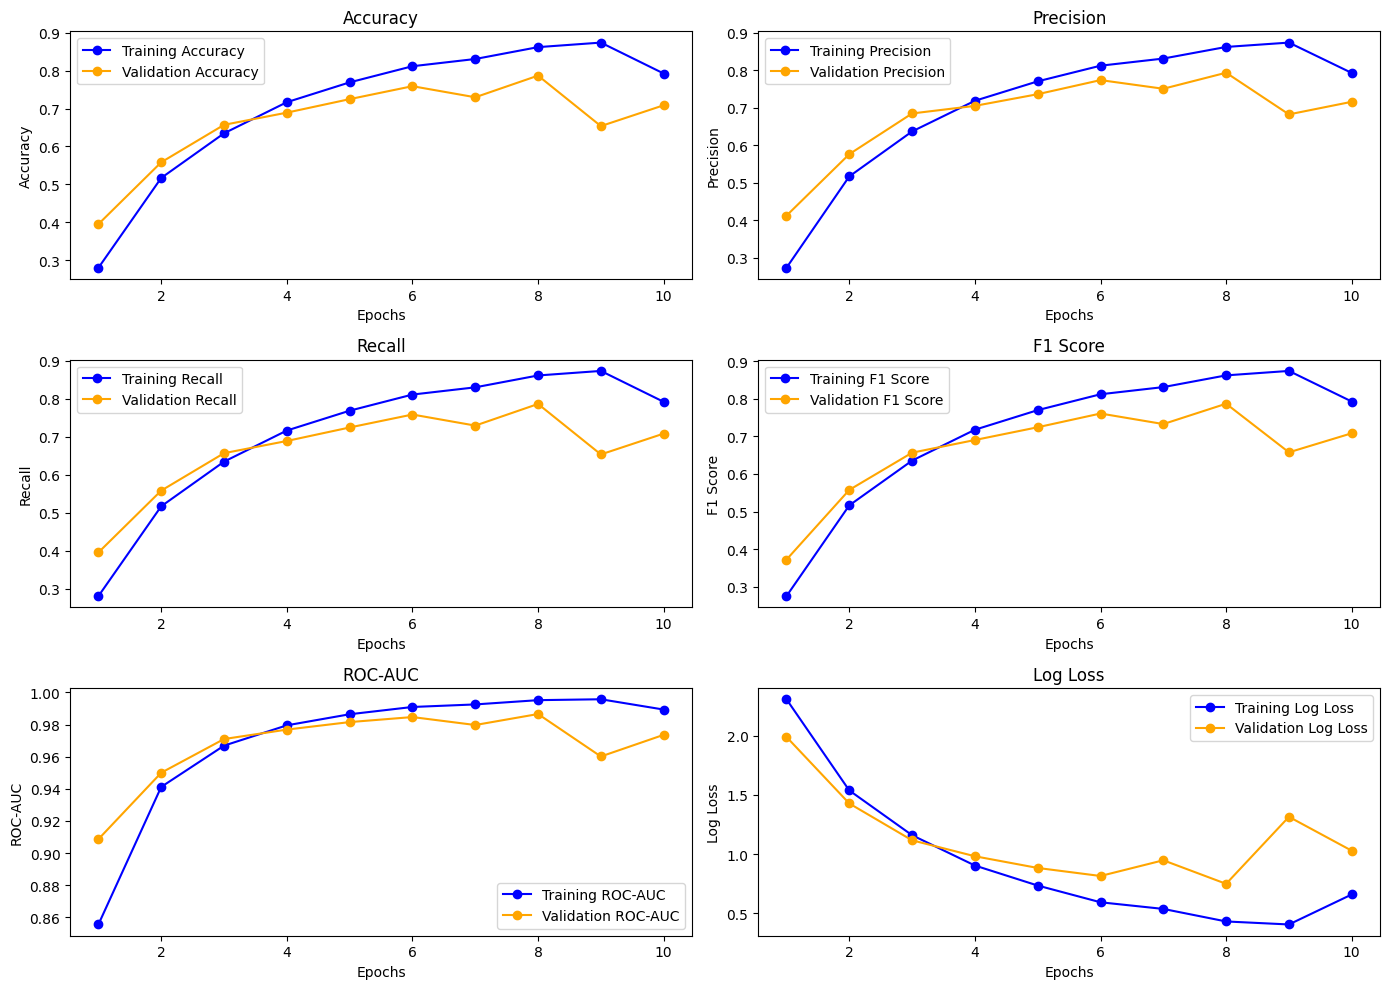

<Figure size 640x480 with 0 Axes>

In [93]:
epochs_range = range(1, len(train_metrics['accuracy']) + 1)

plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(epochs_range, train_metrics['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_metrics['accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Precision
plt.subplot(3, 2, 2)
plt.plot(epochs_range, train_metrics['precision'], label='Training Precision', color='blue', marker='o')
plt.plot(epochs_range, val_metrics['precision'], label='Validation Precision', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()

# Recall
plt.subplot(3, 2, 3)
plt.plot(epochs_range, train_metrics['recall'], label='Training Recall', color='blue', marker='o')
plt.plot(epochs_range, val_metrics['recall'], label='Validation Recall', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()

# F1 Score
plt.subplot(3, 2, 4)
plt.plot(epochs_range, train_metrics['f1'], label='Training F1 Score', color='blue', marker='o')
plt.plot(epochs_range, val_metrics['f1'], label='Validation F1 Score', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

# ROC-AUC
plt.subplot(3, 2, 5)
plt.plot(epochs_range, train_metrics['roc_auc'], label='Training ROC-AUC', color='blue', marker='o')
plt.plot(epochs_range, val_metrics['roc_auc'], label='Validation ROC-AUC', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()

# Log Loss
plt.subplot(3, 2, 6)
plt.plot(epochs_range, train_metrics['log_loss'], label='Training Log Loss', color='blue', marker='o')
plt.plot(epochs_range, val_metrics['log_loss'], label='Validation Log Loss', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Log Loss')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/result.jpg')

In [88]:
from torchsummary import summary

_ = summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
|    └─Conv2d: 2-5                       307,392
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  384
|    └─MaxPool2d: 2-8                    --
|    └─Conv2d: 2-9                       663,936
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 768
|    └─Conv2d: 2-12                      884,992
|    └─ReLU: 2-13                        --
|    └─BatchNorm2d: 2-14                 512
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─BatchNorm2d: 2-17                 512
|    └─MaxPool2d: 2-18                   --
|    └─AdaptiveAvgPool2d: 2-19           --
├─Sequential: 1-2                        -

In [89]:
torch.save(model, "model.pth")